# Tortured sentences detection: dataset building and exploratory analysis

Author: Alexandre Clausse.

## Introduction

This document aims to present an exploratory data analysis and the necessary processing to be done on the dataset extracted from the "Invitations for human assessors" [Problematic Paper Screener](https://www.irit.fr/~Guillaume.Cabanac/problematic-paper-screener) (PPS) assessments. This work is realised in the context of tortured sentences detection in scientific articles.

Data have been gathered from the PPS website, the left tab allowing us to select different detectors, we select the "Tortured" one:

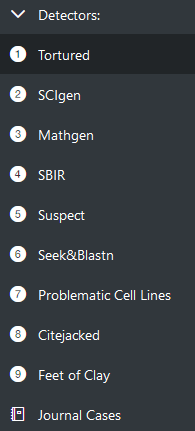

From the search form, we select the "Invitations for human assessors" and filter results to only keep "DOI" and "Tortured Phrases" columns (these are required, we can choose to not filter columns):

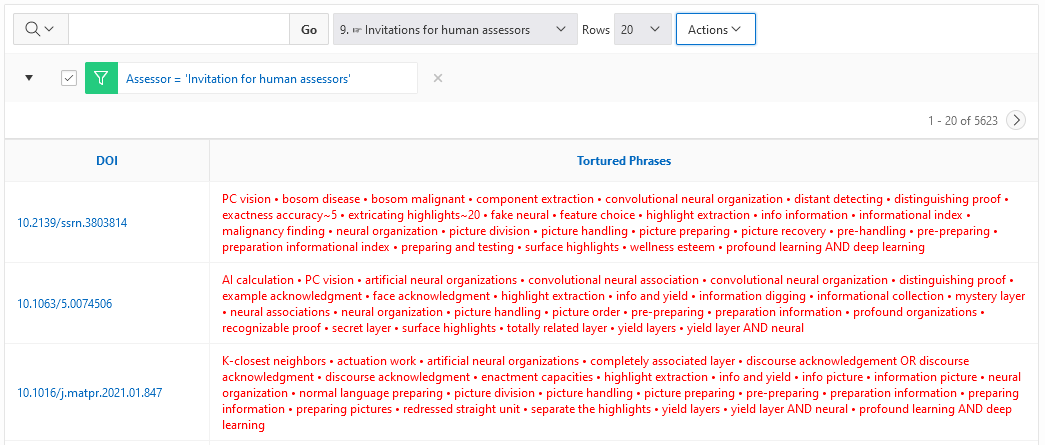

Then we download the results in CSV format.

Considering the extracted assessments, we gather the associated scientific papers (in PDF format), and we match them together in order to extract papers contents. Then we explore the dataset by analysing it.

The raw dataset contains 3,091 assessments for 2,110 associated papers, we only keep common assessments and papers to build a final dataset of 2,043 elements.

## Requirements

We run this data analysis with Python 3.10.

We use the following libraries:
```
pandas==1.5.0      # A data science library
PyPDF2==3.0.1      # A PDF handler
nltk==3.7          # A NLP toolkit
unidecode==1.3.6   # To decode unicode characters
tqdm==4.64.1       # To use progress bars for long operations
numpy==1.24.1      # For scientific computations
seaborn==0.12.2    # To plot data analysis results
matplotlib==3.6.3  # Used in addition to Seaborn
gensim==4.3.0      # For topic modeling
wordcloud==1.8.2.2 # For word clouds
ipywidgets==8.0.4  # IPython widgets
```

These can be stored in a list in order to be installed with the `pip3 install -r dependencies.txt` command.

Documentations:
- Pandas: https://pandas.pydata.org/docs/
- PyPDF2: https://pypdf2.readthedocs.io/en/3.0.0/
- NLTK: https://www.nltk.org/
- Unidecode: https://pypi.org/project/Unidecode/
- Numpy: https://numpy.org/doc/stable/index.html
- Matplotlib: https://matplotlib.org/stable/index.html
- Seaborn: https://seaborn.pydata.org/
- Gensim: https://pypi.org/project/gensim/
- Wordcloud: https://pypi.org/project/wordcloud/
- Ipywidgets: https://ipywidgets.readthedocs.io/en/stable/

We also use the following built-in Python libraries:
```
os     # For OS operations
io     # For I/O operations
re     # For regex operations
pickle # For object serialisation and persistence
glob   # For Linux-like path exploration
```

In [1]:
# Imports
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import pos_tag, download as nltkdl
from unidecode import unidecode
from PyPDF2 import PdfReader
from glob import glob
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import gensim
import os, io, re, pickle

tqdm.pandas()
SEED = 1337

## Dataset building

First of all we read the assessments stored in CSV format:

In [3]:
# Reading assessments
assessments = pd.read_csv(os.path.join("raw_data", "_assessments.csv"), encoding="cp1252")
display(assessments.head())

,All Tips,Altmetric,Assessor,Citations,DOI,Detector,Doctype,PubPeer Users,Publisher,Title,Tortured Phrases,Venue,Year
0,15,0,Invitation for human assessors,4,10.1109/iccmc51019.2021.9418051,"suspect, tortured",proceeding,–,Institute of Electrical and Electronics Engine...,A Convenient Machine Learning Model for Cyber ...,concealed layer • counterfeit neural • fluffy ...,2021 5th International Conference on Computing...,2021
1,15,0,Invitation for human assessors,1,10.1109/iceca52323.2021.9676104,"suspect, tortured",proceeding,–,Institute of Electrical and Electronics Engine...,IMPROVED FACE RECOGNITION USING CONVOLUTIONAL ...,blunder rate • condition of-craftsmanship • cr...,2021 5th International Conference on Electroni...,2021
2,15,0,Invitation for human assessors,1,10.1109/icacccn.2018.8748454,"suspect, tortured",proceeding,–,Institute of Electrical and Electronics Engine...,An Overview of Anomaly Detection in Video Surv...,Wavelet change • bolster vector machine • choi...,2018 International Conference on Advances in C...,2018
3,15,0,Invitation for human assessors,0,10.1109/icears53579.2022.9751876,"suspect, tortured",proceeding,–,Institute of Electrical and Electronics Engine...,Anomaly Identification Performed Independently...,bogus up-sides • decent contender • dimensiona...,2022 International Conference on Electronics a...,2022
4,15,0,Invitation for human assessors,0,10.1109/icears53579.2022.9752228,"suspect, tortured",proceeding,–,Institute of Electrical and Electronics Engine...,AI in Terpenes Categorization using: GC and MS...,crude information • decidedly charged • direct...,2022 International Conference on Electronics a...,2022


We build the dataset by keeping document whose DOI is in the upper list:

In [4]:
# Filtering the upper list
assessments = assessments[["DOI", "Tortured Phrases"]]
assessments["filename"] = assessments["DOI"].progress_apply(lambda s: "%s.pdf" % (s.split("/")[-1]))
display(assessments.head())

,DOI,Tortured Phrases,filename
0,10.1109/iccmc51019.2021.9418051,concealed layer • counterfeit neural • fluffy ...,iccmc51019.2021.9418051.pdf
1,10.1109/iceca52323.2021.9676104,blunder rate • condition of-craftsmanship • cr...,iceca52323.2021.9676104.pdf
2,10.1109/icacccn.2018.8748454,Wavelet change • bolster vector machine • choi...,icacccn.2018.8748454.pdf
3,10.1109/icears53579.2022.9751876,bogus up-sides • decent contender • dimensiona...,icears53579.2022.9751876.pdf
4,10.1109/icears53579.2022.9752228,crude information • decidedly charged • direct...,icears53579.2022.9752228.pdf


In [7]:
# Removing files not in assessments list
raw_papers = os.path.join("raw_data", "papers")
dois = list(assessments["filename"])
for f in os.listdir(raw_papers):
    if f not in dois:
        os.remove(os.path.join(raw_papers, f))
print("Remaining %d files" % len(os.listdir(raw_papers)))

Remaining 2043 files


In [8]:
# Removing assessments not in files list
metadata = list()
cols = assessments.columns
for d in dois:
    if d in list(os.listdir(raw_papers)):
        metadata.append(list(assessments.loc[assessments["filename"] == d].values[0]))
print("Kept %d assessments" % len(metadata))

Kept 2043 assessments


In [9]:
# Saving results as the dataset metadata
metadata = pd.DataFrame(metadata, columns=cols)
display(metadata.head())
metadata.to_csv(os.path.join("dataset", "_metadata.csv"), index=False)

,DOI,Tortured Phrases,filename
0,10.1109/iccmc51019.2021.9418051,concealed layer • counterfeit neural • fluffy ...,iccmc51019.2021.9418051.pdf
1,10.1109/iceca52323.2021.9676104,blunder rate • condition of-craftsmanship • cr...,iceca52323.2021.9676104.pdf
2,10.1109/icacccn.2018.8748454,Wavelet change • bolster vector machine • choi...,icacccn.2018.8748454.pdf
3,10.1109/icears53579.2022.9751876,bogus up-sides • decent contender • dimensiona...,icears53579.2022.9751876.pdf
4,10.1109/icears53579.2022.9752228,crude information • decidedly charged • direct...,icears53579.2022.9752228.pdf


As we filtered the papers to be in our final dataset, we can now extract their contents:

In [3]:
# Extracting files contents
def replace_filetype(src:str) -> str:
    src = src.split(".")
    src[-1] = "txt"
    src = ".".join(src)
    return src

def read_pdf(src:str) -> str:
    reader = PdfReader(src)
    content = "\n".join([e.extract_text() for e in reader.pages])
    return content

#metadata = pd.read_csv(os.path.join("dataset", "_metadata.csv"), encoding="utf-8")
for f in metadata["filename"]:
    content = read_pdf(os.path.join(raw_papers, f))
    with io.open(os.path.join("dataset", replace_filetype(f)), "w", encoding="utf-8") as handle:
        handle.write(content)
        handle.close()
print("Extracted contents from %d papers" % len(glob(os.path.join("dataset", "*.txt"))))

Extracted contents from 2043 papers


## Dataset analysis

### Exploring the dataset

First, we read data:

In [2]:
# Reading metadata
metadata = pd.read_csv(os.path.join("dataset", "_metadata.csv"), encoding="utf-8")
display(metadata.head())

,DOI,Tortured Phrases,filename
0,10.1109/iccmc51019.2021.9418051,concealed layer • counterfeit neural • fluffy ...,iccmc51019.2021.9418051.pdf
1,10.1109/iceca52323.2021.9676104,blunder rate • condition of-craftsmanship • cr...,iceca52323.2021.9676104.pdf
2,10.1109/icacccn.2018.8748454,Wavelet change • bolster vector machine • choi...,icacccn.2018.8748454.pdf
3,10.1109/icears53579.2022.9751876,bogus up-sides • decent contender • dimensiona...,icears53579.2022.9751876.pdf
4,10.1109/icears53579.2022.9752228,crude information • decidedly charged • direct...,icears53579.2022.9752228.pdf


In [3]:
# Reading papers
def read_content(path:str) -> str:
    with io.open(path, "r", encoding="utf-8") as handle:
        content = handle.read()
        handle.close()
    return content

metadata["content"] = metadata["DOI"].progress_apply(lambda p: read_content(os.path.join("dataset", "%s.txt" % (p.split("/")[-1]))))
display(metadata.head())

100%|██████████| 2043/2043 [00:01<00:00, 1498.25it/s]


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,concealed layer • counterfeit neural • fluffy ...,iccmc51019.2021.9418051.pdf,A Convenient Machine Learning Model for Cyber ...
1,10.1109/iceca52323.2021.9676104,blunder rate • condition of-craftsmanship • cr...,iceca52323.2021.9676104.pdf,IMPROVED FACE RECOGNITION USING \nCONVOLUTIONA...
2,10.1109/icacccn.2018.8748454,Wavelet change • bolster vector machine • choi...,icacccn.2018.8748454.pdf,International Conference on Advances in Comput...
3,10.1109/icears53579.2022.9751876,bogus up-sides • decent contender • dimensiona...,icears53579.2022.9751876.pdf,\nAnomaly Identification Performed Independen...
4,10.1109/icears53579.2022.9752228,crude information • decidedly charged • direct...,icears53579.2022.9752228.pdf,"\nG MANI \nAssistant Professor, Department of..."


We visualise data and metadata examples:

In [5]:
# Visualising tortured sentences examples
print(metadata.head()["Tortured Phrases"].values)

['concealed layer • counterfeit neural • fluffy rationale • gatherings clustering~10 • hereditary calculation • highlight extraction • keen matrix • preparation information • profound neural organization • profound neural system • profound learning AND deep learning'
 'blunder rate • condition of-craftsmanship • crude information • discrete cosine change • facial highlights • feeling acknowledgment • head part examination • man-made consciousness • misfortune layer • pre-handling • preparation information • profound convolutional • profound learning AND deep learning'
 'Wavelet change • bolster vector machine • choice tree • convolutional neural system • help vector machine • likelihood appropriation • profound convolutional • shrouded Markov'
 'bogus up-sides • decent contender • dimensionality decrease • head part examination • highlight extraction • preparation information • profound learning AND deep learning'
 'crude information • decidedly charged • direct relapse • disarray netw

Since our output has a data rate limit, we display some papers DOI instead of their associated content, nevertheless highlighting some remarks:

In [6]:
# Displaying the DOI of disimilar papers
print(metadata["DOI"].values[0])   # This is a regular paper
print(metadata["DOI"].values[343]) # This paper does not have an abstract header
print(metadata["DOI"].values[92])  # This paper contains a bibliography header instead of references

10.1109/iccmc51019.2021.9418051
10.1109/i-smac.2018.8653688
10.1109/acit.2018.8672673


We can see in the metadata that each paper is associated to a list of tortured phrase separated with a "•". Some tortured phrases can have this format: `tortured phrase [OR other tortured phrase] [AND suggested correction [AND other suggested correction]]`.

The extracted content is noisy, including papers metadata (e.g. authors and affiliations), references, captions and control characters (e.g. "\n"). Some of these control characters separate sentences, as some whitespaces seperate words. 

We perform a first processing in order to correct these problems:

In [4]:
# Metadata processing
def process_tortured_sentences(s:str) -> list:
    processed_sentences = list()
    s = s.lower().split(" • ")                                   # sentences lowerisation and splitting
    for e in s:
        processed_sentences += e.split(" AND ")[0].split(" OR ") # keeping only tortured sentence(s)
    return processed_sentences

metadata["Tortured Phrases"] = metadata["Tortured Phrases"].progress_apply(process_tortured_sentences)
print(metadata.head()["Tortured Phrases"].values)

100%|██████████| 2043/2043 [00:00<00:00, 58916.30it/s]

[list(['concealed layer', 'counterfeit neural', 'fluffy rationale', 'gatherings clustering~10', 'hereditary calculation', 'highlight extraction', 'keen matrix', 'preparation information', 'profound neural organization', 'profound neural system', 'profound learning and deep learning'])
 list(['blunder rate', 'condition of-craftsmanship', 'crude information', 'discrete cosine change', 'facial highlights', 'feeling acknowledgment', 'head part examination', 'man-made consciousness', 'misfortune layer', 'pre-handling', 'preparation information', 'profound convolutional', 'profound learning and deep learning'])
 list(['wavelet change', 'bolster vector machine', 'choice tree', 'convolutional neural system', 'help vector machine', 'likelihood appropriation', 'profound convolutional', 'shrouded markov'])
 list(['bogus up-sides', 'decent contender', 'dimensionality decrease', 'head part examination', 'highlight extraction', 'preparation information', 'profound learning and deep learning'])
 list

In [5]:
# Content processing
metadata["content"] = metadata["content"].progress_apply(lambda s: s.lower().replace("\n", "")) # sentence lowerisation and "\n" removal

100%|██████████| 2043/2043 [00:01<00:00, 1697.31it/s]


<u>Remark</u>: due to a lack of time to process the dataset, we only removed "\n" characters, the others processing we be applyed during further experimentations.

We move to content analysis.

### Analysing text statistics

We perform text analysis such as word frequency, sentence length and average word length analysis.

To do that, we also perform supplementary processings:

In [6]:
# Processing dataset
def process_content(c:str) -> list:
    c = sent_tokenize(c)                            # sentence tokenisation
    c = [unidecode(e) for e in c]                   # unicode decoding for accents removal
    c = [e.replace("_", " ") for e in c]            # underscore replacement
    c = [re.sub("[^0-9a-zA-Z ]", "", e) for e in c] # keeping only whitespaces and alphanumeric characters
    c = [word_tokenize(e) for e in c]               # word tokenisation including supplementary whitespaces removal
    return c

#nltkdl("punkt")
metadata["content"] = metadata["content"].progress_apply(process_content)
display(metadata.head())

100%|██████████| 2043/2043 [04:18<00:00,  7.90it/s] 


,DOI,Tortured Phrases,filename,content
0,10.1109/iccmc51019.2021.9418051,"[concealed layer, counterfeit neural, fluffy r...",iccmc51019.2021.9418051.pdf,"[[a, convenient, machine, learning, model, for..."
1,10.1109/iceca52323.2021.9676104,"[blunder rate, condition of-craftsmanship, cru...",iceca52323.2021.9676104.pdf,"[[improved, face, recognition, using, convolut..."
2,10.1109/icacccn.2018.8748454,"[wavelet change, bolster vector machine, choic...",icacccn.2018.8748454.pdf,"[[international, conference, on, advances, in,..."
3,10.1109/icears53579.2022.9751876,"[bogus up-sides, decent contender, dimensional...",icears53579.2022.9751876.pdf,"[[anomaly, identification, performed, independ..."
4,10.1109/icears53579.2022.9752228,"[crude information, decidedly charged, direct ...",icears53579.2022.9752228.pdf,"[[g, mani, assistant, professor, department, o..."


In [8]:
# Performing data analysis
sents_lens = list()     # sentence length in each paper
words_count = list()    # number of words in each paper
avg_words_lens = list() # average word length in each sentence in each paper
for i in tqdm(range(len(metadata["content"].values))):
    paper = metadata["content"].values[i]
    sents_lens += [len(" ".join(sentence)) for sentence in paper]
    words_count.append(np.sum([len(sentence) for sentence in paper], dtype=np.int64))
    avg_words_lens += [np.average(np.array([len(word) for word in sentence], dtype=np.float64)) for sentence in paper]

100%|██████████| 2043/2043 [00:15<00:00, 133.43it/s]


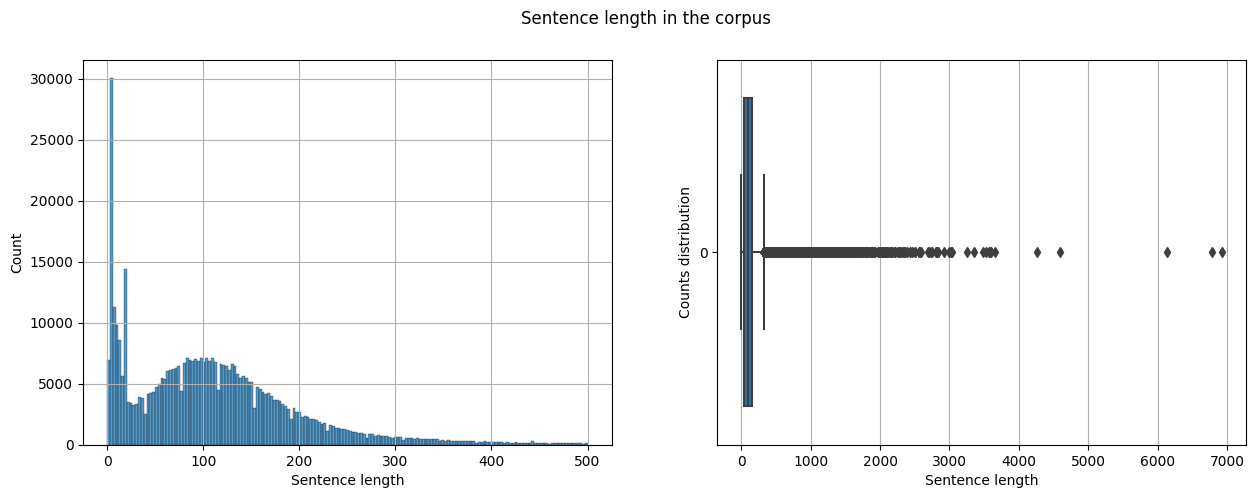

In [9]:
# Displaying sentence length in each paper
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    ax.grid()
sns.histplot(data=sents_lens, binrange=(0, 500), ax=axes[0])
axes[0].set_xlabel("Sentence length")
sns.boxplot(data=sents_lens, ax=axes[1], orient="h")
axes[1].set_xlabel("Sentence length")
axes[1].set_ylabel("Counts distribution")
fig.suptitle("Sentence length in the corpus")
plt.show()

In [16]:
# Exploring small sentences
small_sent = list()
length = 20
for paper in metadata["content"]:
    for sentence in paper:
        joined_sent = " ".join(sentence)
        if (len(joined_sent) < length) and (joined_sent not in small_sent):
            small_sent.append(joined_sent)
small_sent = pd.Series(small_sent)
display(small_sent.head(10))

0                    ii
1    restrictions apply
2                   iii
3                    vi
4                 35 no
5                  1 pp
6        53 65 jan 2018
7                  6 pp
8         83948402 2018
9            press 2014
dtype: object

In [25]:
# Exploring long setences
long_sent = list()
length = 2000
for paper in metadata["content"]:
    for sentence in paper:
        joined_sent = " ".join(sentence)
        if (len(joined_sent) > length) and (joined_sent not in long_sent):
            long_sent.append(joined_sent)
long_sent = pd.Series(long_sent)
display(long_sent.head(10))

0    alla m eid amgad a salama hassan m elkamchouch...
1    mansour mohamed e hanafy track 31 iot m2m sens...
2    amar ahmed ibrahim salem naser ojaroudi parchi...
3    of e lectronics and communications engineering...
4    10731081 2018table iii numerical results of th...
5    rmse s of training validation and testing sets...
6    artificial intelligence and its related domain...
7    aircraft failure rate forecasting method based...
8    disappointment recuperation plancherelscheckpo...
9    references 1 suma v ramya r shekar akshay kuma...
dtype: object

Given the upper figures, we can see that the sentence lengths distribution is left-skewed with a lot of outliers and short sentences. The small sentences are generally noise such as title numbers, legal mentions (e.g. "restrictions apply"), metadata (e.g. publication date and editor), single words, and there are also empty sentences. The long sentences are generally references and tables, there are noisy content (e.g. words with duplicated chracaters or merged sentences), due to the extraction. Some of these outliers sould not be deleted since they are dissertations contents, this is due to many processing not done yet on the dataset.

Generally, the sentences lengths range from 0 to 300 characters.

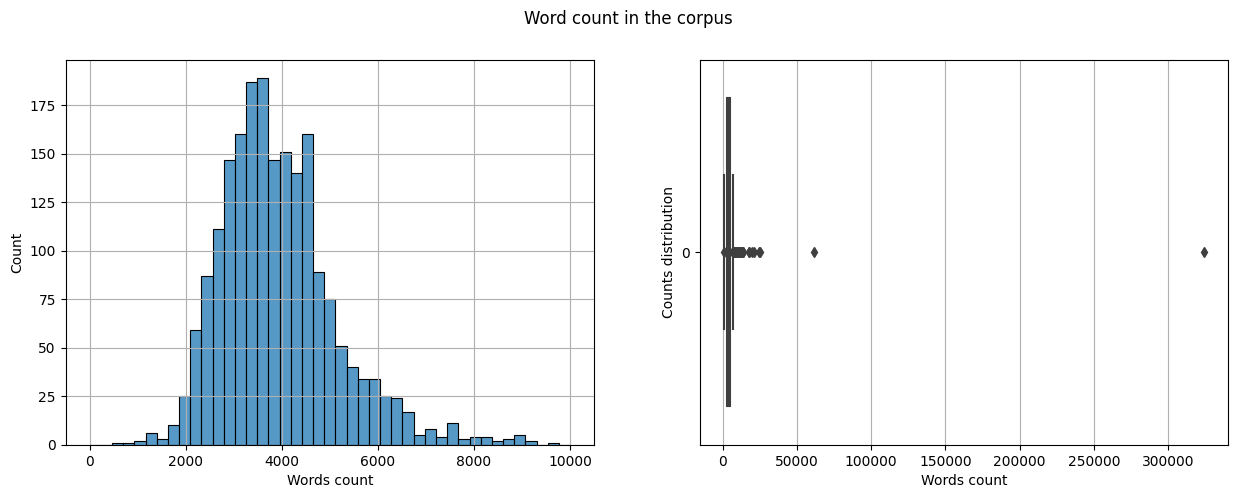

In [10]:
# Displaying number of words in each paper
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    ax.grid()
sns.histplot(data=words_count, binrange=(0, 10000), ax=axes[0])
axes[0].set_xlabel("Words count")
sns.boxplot(data=words_count, ax=axes[1], orient="h")
axes[1].set_xlabel("Words count")
axes[1].set_ylabel("Counts distribution")
fig.suptitle("Word count in the corpus")
plt.show()

In [31]:
# Searching for huge papers
size = 10000
for i in range(len(metadata.values)):
    pwc = np.sum([len(sentence) for sentence in metadata.values[i][-1]], dtype=np.int64)
    if pwc > size:
        print(metadata.values[i][-2])

access.2019.2935220.pdf
itc-egypt55520.2022.9855762.pdf
icrito51393.2021.9596247.pdf
csde50874.2020.9411547.pdf
access.2021.3059858.pdf
jsen.2021.3055618.pdf
access.2020.3042273.pdf
tit.2010.2050935.pdf
access.2021.3108395.pdf
jlt.2005.856165.pdf
access.2021.3097102.pdf
ssrn.3781292.pdf
5905230.pdf
3201644.pdf
2568347.pdf
5450826.pdf


Given the upper figures, we can see that the words count distribution is left-skewed, meaning that there are not only papers in the corpus, but also some books. After further investigation, there are thesis and conference proceedings in the corpus.

Generally, the number of words in each paper ranges from 2000 to 6500.

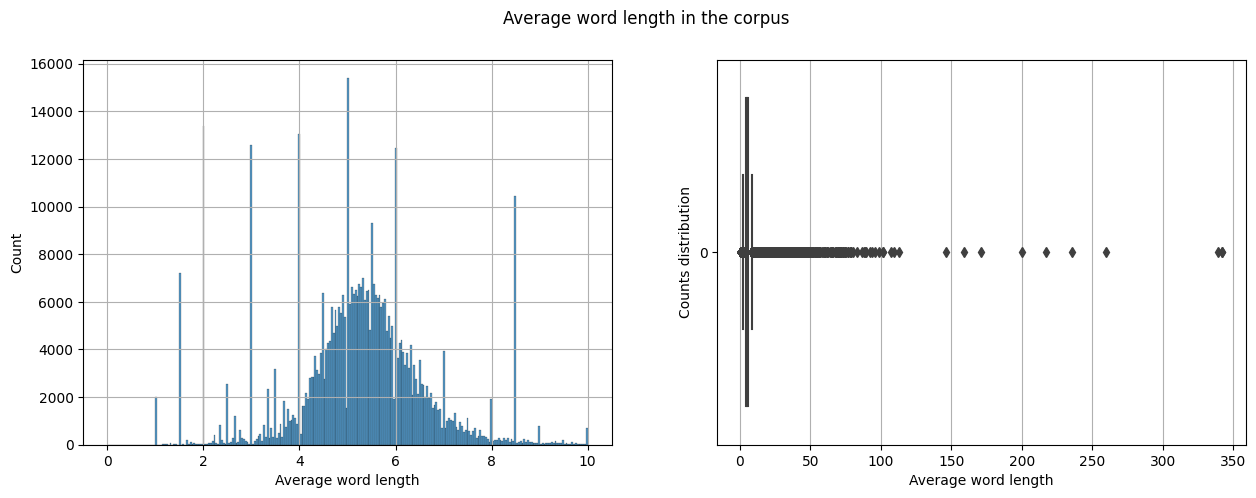

In [20]:
# Displaying average word length in each sentence in each paper
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    ax.grid()
sns.histplot(data=avg_words_lens, binrange=(0, 10), ax=axes[0])
axes[0].set_xlabel("Average word length")
sns.boxplot(data=avg_words_lens, ax=axes[1], orient="h")
axes[1].set_xlabel("Average word length")
axes[1].set_ylabel("Counts distribution")
fig.suptitle("Average word length in the corpus")
plt.show()

In [27]:
# Exploring outliers
avg_length = 100
for paper in metadata["content"]:
    for sentence in paper:
        sent_len = np.average(np.array([len(word) for word in sentence], dtype=np.float64))
        if sent_len > avg_length:
            print(sentence)

['datasetnd2022internationalconferenceoncomputercommunicationandinformatics', 'icccijan25272022coimbatoreindiavireferences1arturqbdasilvatainvdelawaresandesfreitasjulianabmansurjoseosmarmedicinapestanaandgiannamastroiannikirsztajnclinicalpresentationoutcomesandtreatmentofmembranousrenaldisorderoncetransplantationinternationaljournalofnephrology20182andrewsbombackcfervenzamembranousnephropathyapproachestotreatmentamericanjournalofmay2018']
['httpsdoiorg101109lgrs201423373206jkittlermhatefrobertpwduinjmatas1998onconsolidatingclassifiersieeetransactionsonpatternanalysisandmachineintelligence203226239']
['c1ccccca9dssdp10bbmyijd1i6dj0b1011sxixit1a2011sxixit1a21caij1cca1mm110bbmyijd1i6dj0b1011syiyit1a2011syiyit1a21caij1cca1mm1230bbbbbvuuuuuut10bbmyijd1i6dj0b1011sxixit1a2011sxixit1a21caij1cca1mm11ccccca1']
['cc1ccccccca9dssdp10bbmyijkd1i6dj6dk0b1011sxixit1a2011sxjxjt1a2011sxkxkt1a21caijk1cca1mm1m210bbmyijkd1i6dj6dk0b1011syiyit1a2011syjyjt1a2011sykykt1a21caijk1cca1mm1m2600bbbbbvuuuuuut10bbmyi

In [12]:
# Exploring most reccurrent common lengths sentences
common_lens = [1., 1.5, 2., 3., 4., 5., 6., 8.5]
common_sent = list()
for paper in metadata["content"]:
    for sentence in paper:
        sent_len = np.average(np.array([len(word) for word in sentence], dtype=np.float64))
        joined_sent = " ".join(sentence)
        if (sent_len in common_lens) and (joined_sent not in common_sent):
            common_sent.append(joined_sent)
common_sent = pd.Series(common_sent)
display(common_sent.head(10))
            

0    this research work proposes a gan based model ...
1    ai based security models are the most notable ...
2                                                   ii
3                                   restrictions apply
4    hereditary calculations fluffy rationale naive...
5                                                  iii
6    because of these deficiencies deep learning ba...
7    any exercises performed during a security brea...
8    overseen learning is used when a dataset of st...
9    sinc e the generator was prepared to show the ...
dtype: object

Given the upper figures, we can see that the average words length distribution is left-skewed, also due to the previous undone rocessing.

Generally, the average word length in each paper ranges from 4 to 7, but there are common lengths such as 1, 2, 3 and 5, meaning that there are a lot of short words in the papers.

This could be due to the presence of stopwords:

In [13]:
# Gathering top stopwords and other words
#nltkdl("stopwords")
sw = set(stopwords.words("english"))
stop_words = dict()
words = dict()
n_stop_words = 0
n_words = 0
for i in tqdm(range(len(metadata["content"].values))):
    for sentence in metadata["content"].values[i]:
        for word in sentence:
            if word in sw:
                if word not in stop_words.keys():
                    stop_words[word] = 1
                else:
                    stop_words[word] += 1
                n_stop_words += 1
            else:
                if word not in words.keys():
                    words[word] = 1
                else:
                    words[word] += 1
                n_words += 1
print("%d stop words in the corpus" % (n_stop_words))
print("%d other words in the corpus" % (n_words))
top_stop_words = sorted(stop_words.items(), key=lambda x:x[1], reverse=True)
top_words = sorted(words.items(), key=lambda x:x[1], reverse=True)

100%|██████████| 2043/2043 [00:11<00:00, 173.89it/s]


2820756 stop words in the corpus
5766039 other words in the corpus


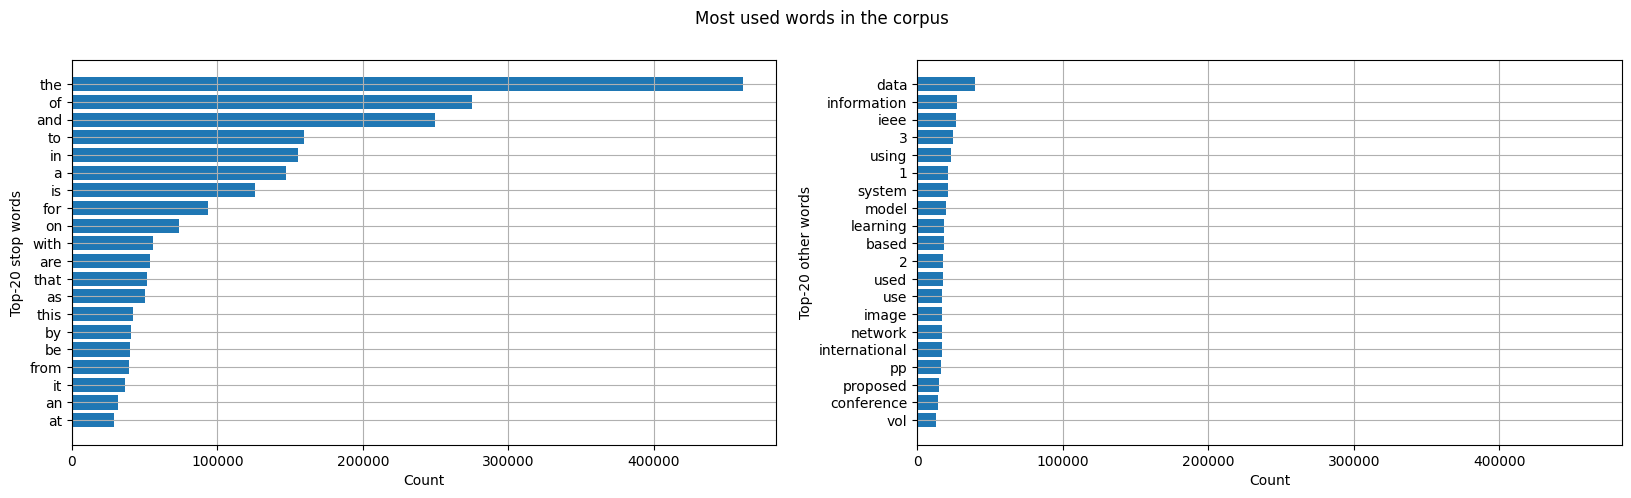

In [23]:
# Plotting top-20 used words
top = 20
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
for ax in axes:
    ax.grid()

sw_x, sw_y = zip(*top_stop_words[:top][::-1])
axes[0].barh(sw_x, sw_y)
axes[0].set_ylabel("Top-%d stop words" % (top))
axes[0].set_xlabel("Count")

w_x, w_y = zip(*top_words[:top][::-1])
axes[1].barh(w_x, w_y)
axes[1].set_ylabel("Top-%d other words" % (top))
axes[1].set_xlabel("Count")

fig.suptitle("Most used words in the corpus")
plt.show()

Given the upper figures, we can see that the top-20 stop words can occur up to 10 times more than the top-20 other words, making the corpus very noisy (its content composed of 32.8% of stopwords). Also the top-20 other words belong to the computer science research field, there is again single characters (e.g. "1", "2" and "3").

Let's make further explorations with the ngrams.

### Exploring ngrams

In order to perform bigrams and trigrams exploration with reducing noise, we exclude stopwords:

In [14]:
# Removing stopwords from contents
non_sw_content = metadata["content"].progress_apply(lambda c: [[word for word in sentence if word not in sw] for sentence in c])
display(non_sw_content.head())

100%|██████████| 2043/2043 [00:04<00:00, 428.41it/s]


0    [[convenient, machine, learning, model, cyber,...
1    [[improved, face, recognition, using, convolut...
2    [[international, conference, advances, computi...
3    [[anomaly, identification, performed, independ...
4    [[g, mani, assistant, professor, department, v...
Name: content, dtype: object

In [15]:
# Extracting bigrams and trigrams
bigrams = dict()
trigrams = dict()
for i in tqdm(range(len(non_sw_content.values))):
    for sentence in non_sw_content.values[i]:
        for bigram in list(ngrams(sentence, 2)):
            b = "\n".join(bigram)
            if b not in bigrams.keys():
                bigrams[b] = 1
            else:
                bigrams[b] += 1
        for trigram in list(ngrams(sentence, 3)):
            t = "\n".join(trigram)
            if t not in trigrams.keys():
                trigrams[t] = 1
            else:
                trigrams[t] += 1
top_bigrams = sorted(bigrams.items(), key=lambda x:x[1], reverse=True)
top_trigrams = sorted(trigrams.items(), key=lambda x:x[1], reverse=True)

100%|██████████| 2043/2043 [00:25<00:00, 78.78it/s] 


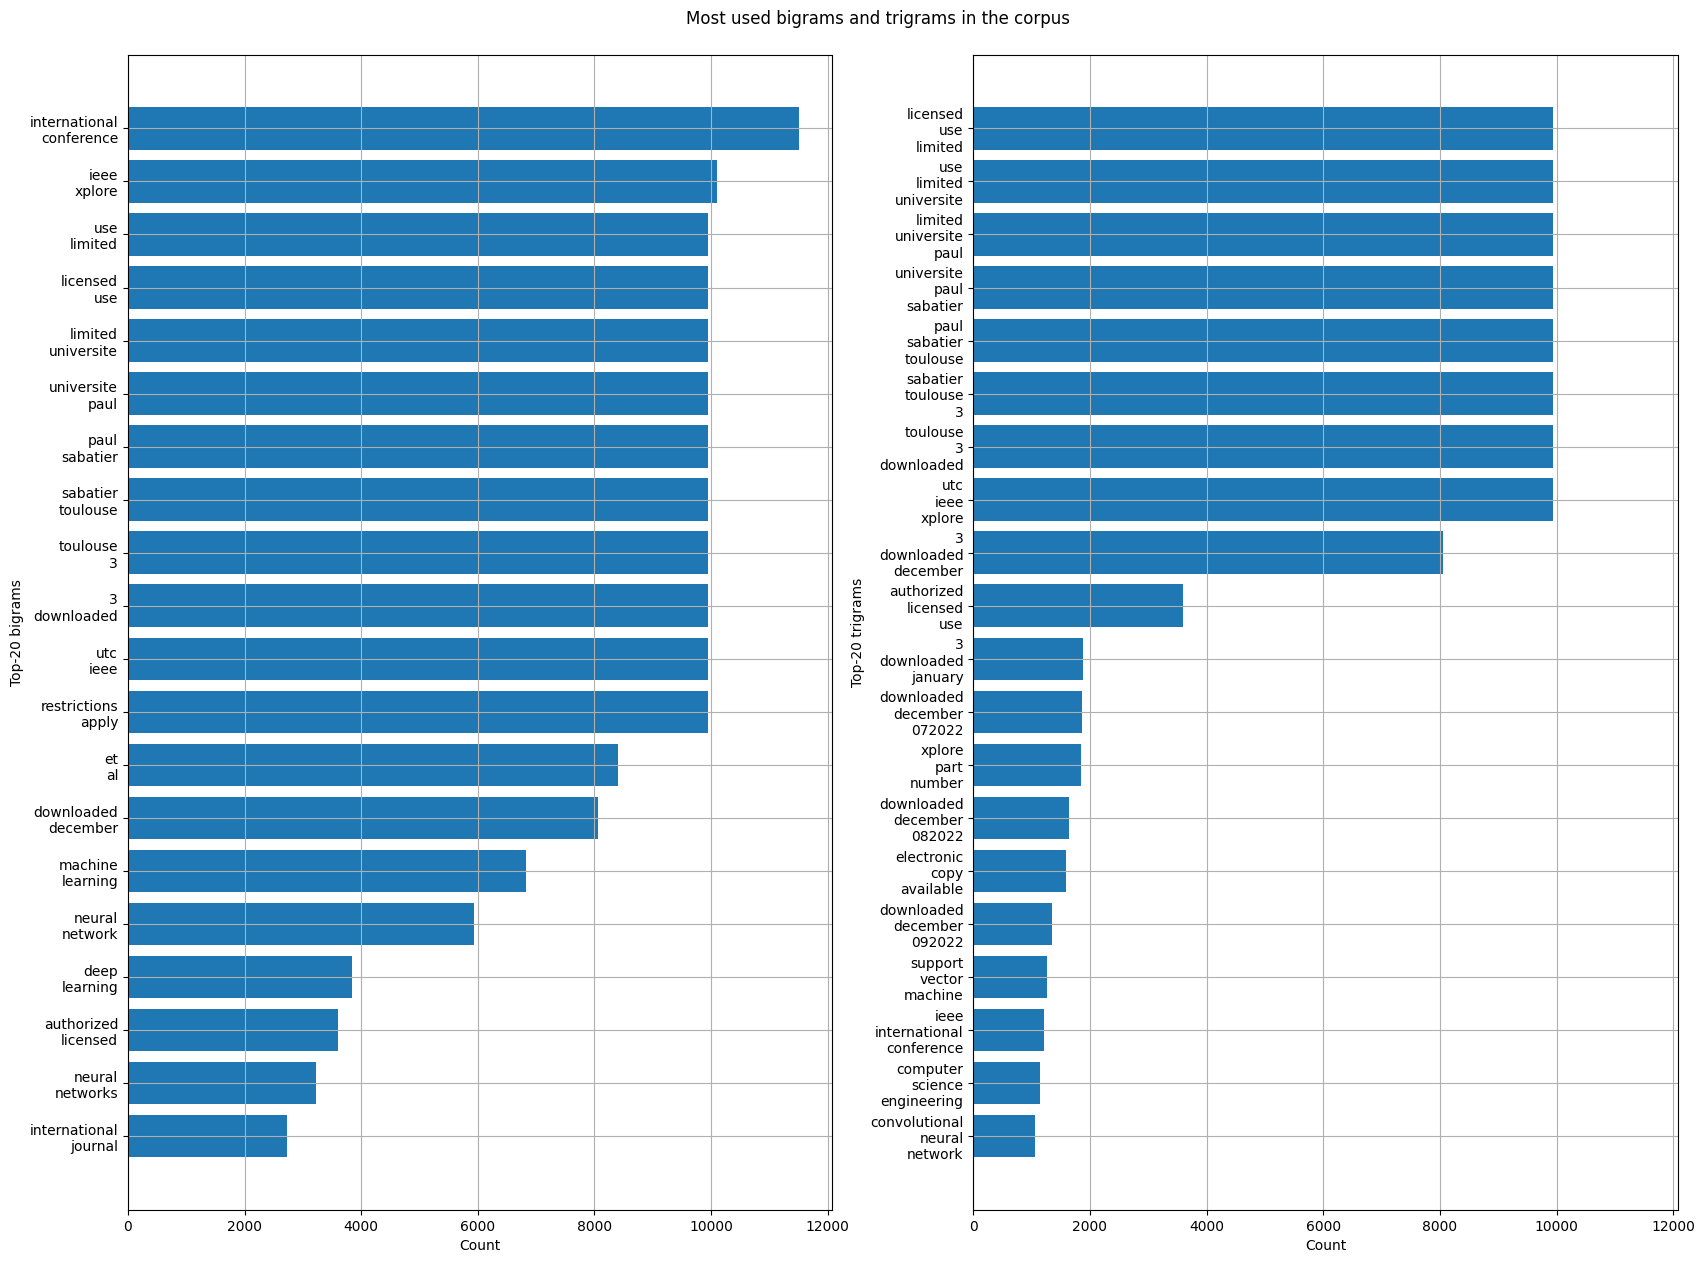

In [16]:
# Plotting top-20 used bigrams and trigrams
top = 20
fig, axes = plt.subplots(1, 2, figsize=(20, 15), sharex=True)
for ax in axes:
    ax.grid()

bi_x, bi_y = zip(*top_bigrams[:top][::-1])
axes[0].barh(bi_x, bi_y)
axes[0].set_ylabel("Top-%d bigrams" % (top))
axes[0].set_xlabel("Count")

tri_x, tri_y = zip(*top_trigrams[:top][::-1])
axes[1].barh(tri_x, tri_y)
axes[1].set_ylabel("Top-%d trigrams" % (top))
axes[1].set_xlabel("Count")

fig.suptitle("Most used bigrams and trigrams in the corpus", y=.91)
plt.show()

Given the upper figures, the most occurring bigrams and trigrams concern legal mentions (e.g. "licensed use limited" and "universite paul sabatier") and metadata (e.g. "ieee international conference" and "downloaded decemebr"). In addition, the monosemy of the corpus is very strong since the reccurent topic seems to be related to machine learning, its lexical field being very redundent.

We make more investigations in the next task.

### Topic modeling

In order to perform topic modeling on the dataset, we remove the most occurrent noise.

Given the upper figures, the top-14 most used bigrams are noise, so are the top-16 trigrams, we consider them as "stopwords" in the below code:

In [17]:
# Removing most occurrent noise
noise = list()

for e in list(top_bigrams)[:14]:
    for word in e[0].split("\n"):
        if word not in noise:
            noise.append(word)

for e in list(top_trigrams)[:16]:
    for word in e[0].split("\n"):
        if word not in noise:
            noise.append(word)

print(noise)

['international', 'conference', 'ieee', 'xplore', 'use', 'limited', 'licensed', 'universite', 'paul', 'sabatier', 'toulouse', '3', 'downloaded', 'utc', 'restrictions', 'apply', 'et', 'al', 'december', 'authorized', 'january', '072022', 'part', 'number', '082022', 'electronic', 'copy', 'available', '092022']


We apply word lemmatisation to group common base or root words:

In [18]:
# Content lemmatisation
corpus = list()
#nltkdl(["wordnet", "omw-1.4"])
lem = WordNetLemmatizer()
for i in tqdm(range(len(non_sw_content.values))):
    words = list()
    for sentence in non_sw_content.values[i]:
        words += [w for w in sentence if w not in noise]
    words = [lem.lemmatize(w) for w in words if len(w) > 2]
    corpus.append(words)

100%|██████████| 2043/2043 [00:48<00:00, 41.72it/s]


We perform topic modelling with Latent Dirichlet Allocation (LDA):

In [19]:
# Creating bag of words and LDA model
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = list()
for i in tqdm(range(len(corpus))):
    bow_corpus.append(dic.doc2bow(corpus[i]))
lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics=5,
    id2word=dic,
    passes=10,
    workers=2
)

100%|██████████| 2043/2043 [00:07<00:00, 282.74it/s]


In [20]:
# Displaying top-5 topics
for e in lda_model.show_topics():
    print(e)

(0, '0.007*"system" + 0.005*"image" + 0.004*"using" + 0.004*"vol" + 0.003*"framework" + 0.003*"based" + 0.003*"signal" + 0.003*"information" + 0.003*"control" + 0.003*"model"')
(1, '0.008*"data" + 0.008*"model" + 0.006*"using" + 0.006*"stock" + 0.005*"prediction" + 0.005*"algorithm" + 0.005*"network" + 0.004*"system" + 0.004*"used" + 0.004*"neural"')
(2, '0.013*"image" + 0.007*"patient" + 0.005*"cancer" + 0.005*"vol" + 0.004*"tumor" + 0.003*"using" + 0.003*"method" + 0.003*"segmentation" + 0.003*"data" + 0.003*"brain"')
(3, '0.010*"network" + 0.009*"system" + 0.009*"node" + 0.008*"data" + 0.007*"sensor" + 0.006*"information" + 0.005*"iot" + 0.005*"energy" + 0.005*"hub" + 0.004*"security"')
(4, '0.010*"data" + 0.007*"information" + 0.007*"model" + 0.007*"image" + 0.007*"learning" + 0.007*"system" + 0.005*"using" + 0.004*"network" + 0.004*"feature" + 0.004*"picture"')


The obtained topics do not teach us more than ngrams exploration, we make a last exploration with a word cloud.

We represent most occurrent words in our corpus:

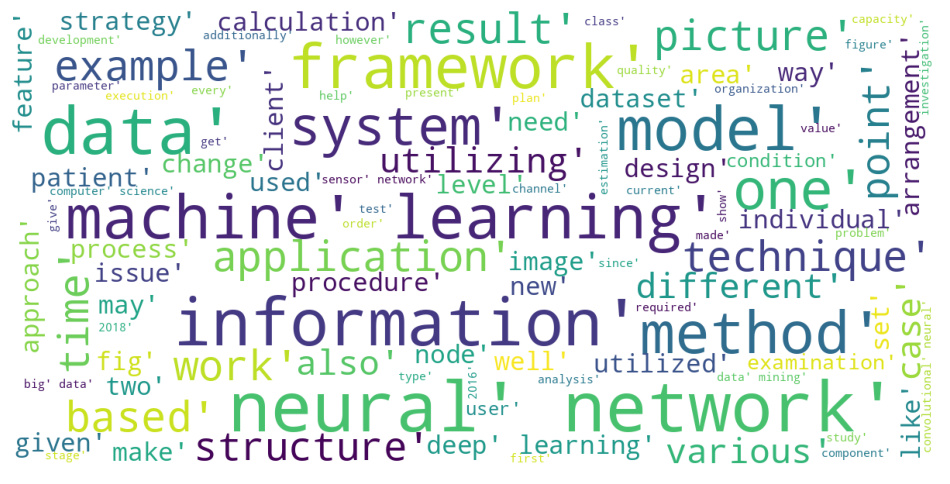

In [21]:
# Generating top-100 occurring words
wc = WordCloud(
    background_color="white",
    stopwords=sw,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=SEED
)
wc = wc.generate(str(corpus))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc)
plt.show()

As previously, this word cloud does not teach us more than ngrams exploration.

We explore furthermore the dataset by performing part of speech tagging.

### Part of speech tagging

We perform POS tagging on the dataset:

In [22]:
# Using POS
#nltkdl("averaged_perceptron_tagger")
tags = list()
for i in tqdm(range(len(metadata["content"].values))):
    for sentence in metadata["content"].values[i]:
        tags += pos_tag(sentence)
s_tags = pd.Series(tags)
display(s_tags.head(10))

100%|██████████| 2043/2043 [13:47<00:00,  2.47it/s] 


0             (a, DT)
1    (convenient, NN)
2       (machine, NN)
3     (learning, VBG)
4         (model, NN)
5           (for, IN)
6         (cyber, JJ)
7      (security, NN)
8       (thanuja, NN)
9             (n, NN)
dtype: object

100%|██████████| 8586795/8586795 [00:08<00:00, 985972.73it/s] 


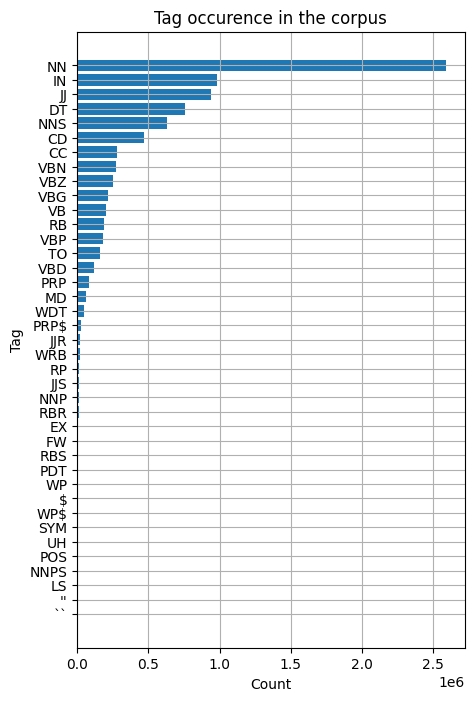

In [23]:
# Displaying tags and their occurences
top_tags = dict()
for i in tqdm(range(len(tags))):
    if tags[i][1] not in top_tags.keys():
        top_tags[tags[i][1]] = 1
    else:
        top_tags[tags[i][1]] += 1

top_tags = sorted(top_tags.items(), key=lambda x:x[1], reverse=True)

fig, ax = plt.subplots(1, figsize=(5, 8))
ax.grid()
tt_x, tt_y = zip(*top_tags[::-1])
ax.barh(tt_x, tt_y)
ax.set_ylabel("Tag")
ax.set_xlabel("Count")
ax.set_title("Tag occurence in the corpus")
plt.show()

The noun (NN) is the most present tag in our dataset, followed by prepositions (IN) and adjectives (JJ), this is typical for dissertations. Some noisy characters are still present, as supposed by the presence of quotes.

Now we investigate which singular noun occurs the most in the dataset:

100%|██████████| 8586795/8586795 [00:03<00:00, 2345476.78it/s]


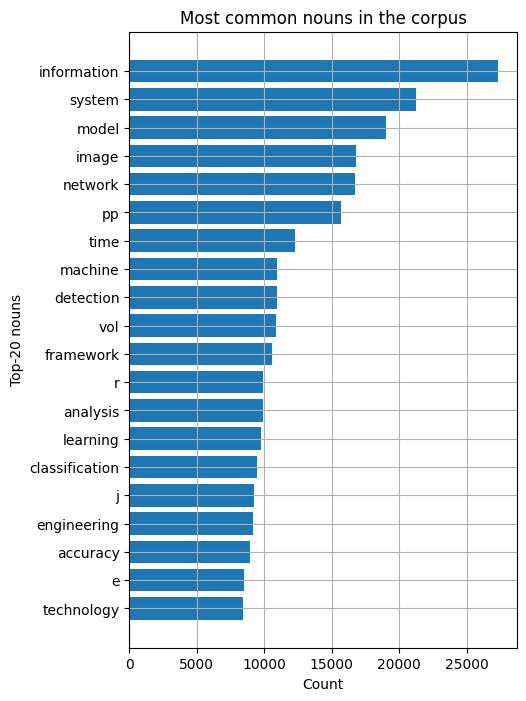

In [31]:
# Displaying nouns occurences
top_nouns = dict()
for i in tqdm(range(len(tags))):
    if (tags[i][1] == "NN") and (tags[i][0] not in sw) and (tags[i][0] not in noise):
        if tags[i][0] not in top_nouns.keys():
            top_nouns[tags[i][0]] = 1
        else:
            top_nouns[tags[i][0]] += 1

top_nouns = sorted(top_nouns.items(), key=lambda x:x[1], reverse=True)

top = 20
fig, ax = plt.subplots(1, figsize=(5, 8))
ax.grid()
tt_x, tt_y = zip(*top_nouns[:top][::-1])
ax.barh(tt_x, tt_y)
ax.set_ylabel("Top-%d nouns" % (top))
ax.set_xlabel("Count")
ax.set_title("Most common nouns in the corpus")
plt.show()

The most common nouns are still in the lexical field of machine learning, there are also noisy content such as single characters.

## Conclusion

During our data exploration, we have seen several necessary processing to be done to clean the corpus, such as sentence tokenisation, non unicode characters removal, undescores replacement, non-alphanumeric characters removal and word tokenisation. There are also a lot of noise in the dataset, such as singles characters, legal mentions, metadata (e.g. publisher and download date), empty sentences, references, tables, captions, distorted content (e.g. merged sentences and duplicated characters), stopwords and quotes. Finally, the monosemy is very strong in the corpus, since most of it concerns the machine learning research field.

If you have any qestion, please contact us at first_name DOT last_name AT irit DOT fr.